<a id='Q0'></a>
<center> <h1> Aviation Herald Project: Clustering</h1> </center>
<p style="margin-bottom:1cm;"></p>
<center><h4>Laurent Bobay, 2024</h4></center>
<p style="margin-bottom:1cm;"></p>

<div style="background:#EEEDF5;border-top:0.1cm solid #EF475B;border-bottom:0.1cm solid #EF475B;">
    <div style="margin-left: 0.5cm;margin-top: 0.5cm;margin-bottom: 0.5cm;color:#303030">
        <p><strong>Goal:</strong> Create dataset of all publicly available articles and comments from www.avherald.com</p>
        <strong> Outline:</strong>
        <a id='P0' name="P0"></a>
        <ol>
            <li> <a style="color:#303030" href='#SU'>Set up</a></li>
            <li> <a style="color:#303030" href='#P1'>Data Exploration and Cleaning</a></li>
            <li> <a style="color:#303030" href='#P2'>Modeling</a></li>
            <li> <a style="color:#303030" href='#P3'>Model Evaluation</a></li>
            <li> <a style="color:#303030" href='#CL'>Conclusion</a></li>
        </ol>
        <strong>Topics Trained:</strong> Notebook Layout, Data Cleaning, Modelling and Model Evaluation
    </div>
</div>

<nav style="text-align:right"><strong>
        <a style="color:#00BAE5" href="https://monolith.propulsion-home.ch/backend/api/momentum/materials/ds-materials/07_MLEngineering/index.html" title="momentum"> Module 7, Machine Learning Engineering </a>|
        <a style="color:#00BAE5" href="https://monolith.propulsion-home.ch/backend/api/momentum/materials/ds-materials/07_MLEngineering/day1/index.html" title="momentum">Day 1, Data Science Project Development </a>|
        <a style="color:#00BAE5" href="https://drive.google.com/file/d/1SOCQu9Gv3jNNXxvJSszBC3fYNsM0df2F/view?usp=sharing" title="momentum"> Live Coding 1, Simple Prediction Notebook</a>
</strong></nav>

In [10]:
import airportsdata

data = airportsdata.load()
data
print(len(data))




28225


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, Markdown
from tqdm import tqdm

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE

from sentence_transformers import SentenceTransformer
import torch

/Users/laurent/anaconda3/envs/ds_final_project/lib/python3.11/site-packages/sentence_transformers/cross_encoder/CrossEncoder.py:11: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


##### Create corpus

In [2]:
# Path to your CSV file
csv_file = "../data/interim/preprocessed_dataset.csv" # title,href,text,time_author

# Define the corpus
df = pd.read_csv(csv_file)
corpus = df.text.tolist()

In [3]:
# Set the device to CPU
device = torch.device('cpu')
model = SentenceTransformer('all-MiniLM-L6-v2', device=device)


# Convert sentences to embeddings
embeddings = model.encode(corpus, show_progress_bar=True)

print(embeddings.shape)

Batches:   0%|          | 0/908 [00:00<?, ?it/s]

(29025, 384)


##### Determine the number of clusters

In [6]:

# To store the errors depending on number of clusters
cluster_errors = []

# Maximum number of clusters
max_clusters = 100


# Try 2 to max_clusters
for n_clusters in tqdm(range(2, max_clusters)):

    # Perform K-Means clustering
    kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(embeddings)

    # Within cluster error
    wcsse = kmeans.inertia_
    cluster_errors.append(wcsse)
    
    # Get cluster labels for each text
    cluster_labels = kmeans.labels_

100%|██████████| 98/98 [02:32<00:00,  1.55s/it]


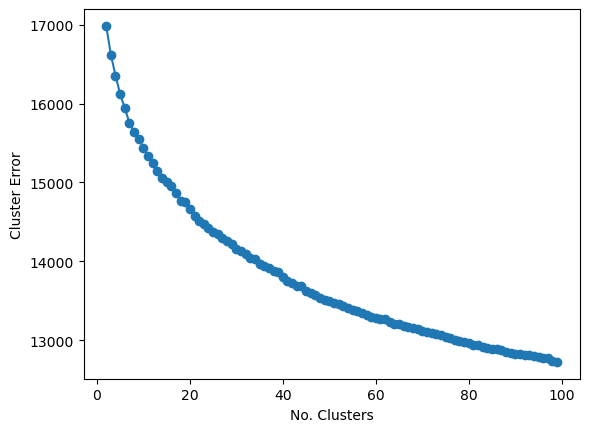

In [7]:
# Elbow plot:
plt.plot(range(2, max_clusters), cluster_errors, "o-")
plt.xlabel("No. Clusters")
plt.ylabel("Cluster Error")
plt.show()

##### Define number of clusters and compute cluster labels

In [8]:
n_clusters = 60

# Perform K-Means clustering with 20 clusters:
kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(embeddings)

# Get cluster labels for each text
cluster_labels = kmeans.labels_

len(cluster_labels)
cluster_labels[:10]

array([ 4,  6, 29, 49, 16, 24, 51, 48, 16, 30], dtype=int32)

##### Dimension reduction

In [11]:
# Now apply t-SNE to the transformed data
tsne = TSNE(n_components=2, random_state=42)  # Using 2 components for a 2D visualization

# Determine batch size
batch_size = 5000

# Initialize progress bar
progress = tqdm(total=len(embeddings), desc="Running t-SNE")

# Initialize results array
X_tsne = np.empty((0, 2))

# Iterate over batches
for i in range(0, len(embeddings), batch_size):
    batch = embeddings[i:i + batch_size]
    X_batch = tsne.fit_transform(batch)
    X_tsne = np.vstack([X_tsne, X_batch])
    
    # Update progress bar
    progress.update(len(batch))

# Close progress bar
progress.close()

Running t-SNE: 100%|██████████| 29025/29025 [02:31<00:00, 191.37it/s]


Running t-SNE:  86%|████████▌ | 25000/29025 [02:21<00:20, 191.86it/s]

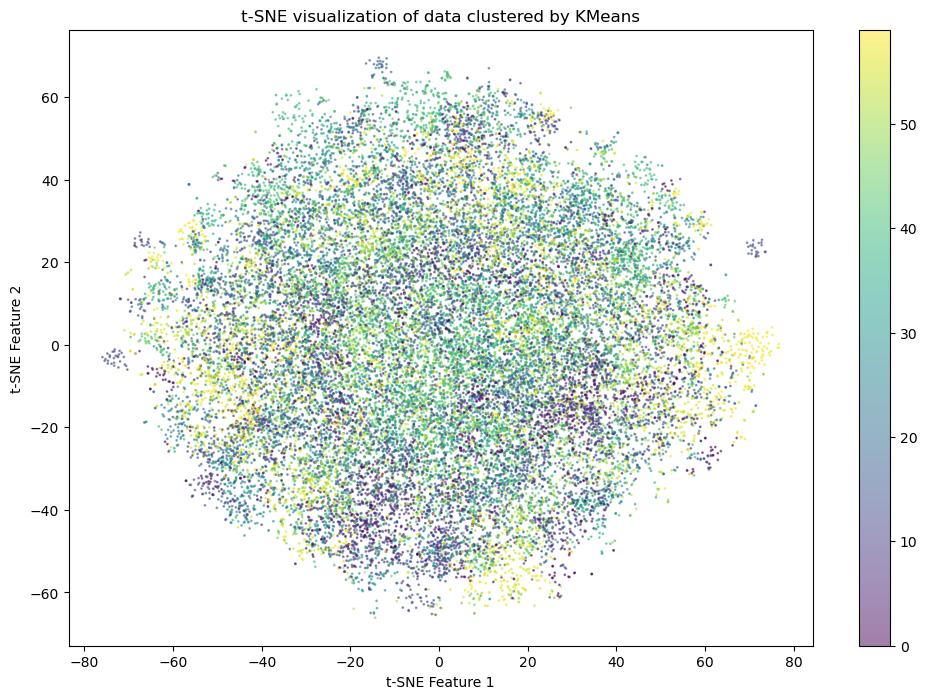

In [10]:
# Plotting the results of t-SNE
plt.figure(figsize=(12, 8))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=cluster_labels, cmap='viridis', alpha=0.5, s=1)
plt.colorbar()
plt.title('t-SNE visualization of data clustered by KMeans')
plt.xlabel('t-SNE Feature 1')
plt.ylabel('t-SNE Feature 2')
plt.show()

<div style="border-top:0.1cm solid #EF475B"></div>
    <strong><a href='#Q0'><div style="text-align: right"> <h3>End of this Notebook.</h3></div></a></strong>